In [8]:
# Information about pdp plotting https://www.kaggle.com/dansbecker/partial-plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from idskicker.config import data_dir

df_start = pd.read_csv(data_dir / 'processed' / '02-ks-projects-engineered.csv')

to_drop = ["ID", "launched", "deadline", 
           "usd_pledged_real", "backers", "launched_year", "deadline_year"]
df = df_start.drop(columns=to_drop)

In [9]:
from idskicker.features import add_n_most_frequent_words_as_features
df["state"] = df["state"].map({"failed":0, "successful":1})
df_copy = df.copy()
add_n_most_frequent_words_as_features(df_copy, "name", 10)
df_copy = df_copy.drop(columns=["name"])

[nltk_data] Downloading package wordnet to /home/emil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/emil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In the baseline model the categorical values were handled by the LGB classifier, but since we want to know the relatsionship of each individual category, we use OHE to convert some values to binary features

In [10]:
df_copy = pd.get_dummies(df_copy, columns=["main_category", "launched_month", "launched_day", 
                                  "deadline_month", "deadline_day"])
for c in df_copy.select_dtypes("object").columns:
    df_copy[c] = df_copy[c].astype('category')

In [11]:
from sklearn.model_selection import train_test_split
X = df_copy.drop(columns=["state"])
y = df_copy["state"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [12]:
import lightgbm as lgb
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'feature_pre_filter': False,
    'lambda_l1': 0.0792934225029538,
    'lambda_l2': 8.403689455946852,
    'num_leaves': 16,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.8726087678345507,
    'bagging_freq': 1,
    'min_child_samples': 20,
    'n_estimators': 1000
}

clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.8726087678345507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8726087678345507
[LightGBM] [Warning] lambda_l2 is set=8.403689455946852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.403689455946852
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.0792934225029538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0792934225029538
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.8726087678345507, bagging_freq=1,
               feature_fraction=0.4, feature_pre_filter=False,
               lambda_l1=0.0792934225029538, lambda_l2=8.403689455946852,
               metric='auc', n_estimators=1000, num_leaves=16,
               objective='binary', verbosity=-1)

In [13]:
from sklearn.metrics import accuracy_score
y_pred=[1 if x > 0.5 else 0 for x in clf.predict(X_test)]
accuracy_score(y_test, y_pred)

0.7043419308488571

In [16]:
from pdpbox import pdp, get_dataset, info_plots
data_features = X_train.columns

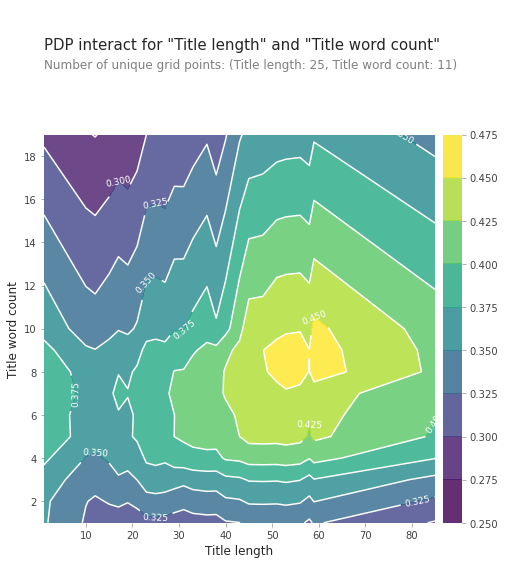

In [109]:
name_words_and_length = pdp.pdp_interact(
    model=clf, dataset=X_test, model_features=data_features, features=["name_length", "name_words"], num_grid_points=[25, 25])
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=name_words_and_length, feature_names=['Title length', 'Title word count'], plot_type='contour'
)

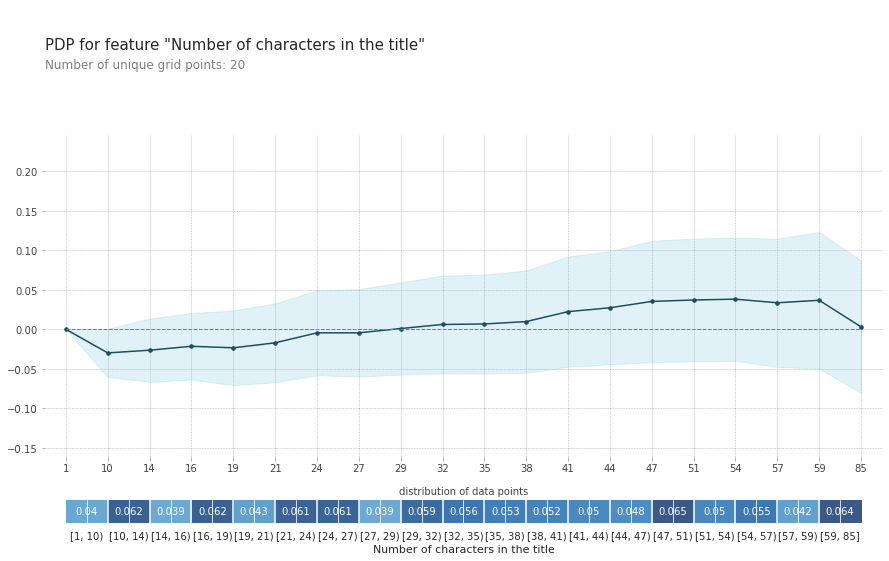

In [105]:
pdp_to_deadline = pdp.pdp_isolate(model=clf, dataset=X_train, model_features=data_features, 
                          feature="name_length", num_grid_points=20)
ax = pdp.pdp_plot(pdp_to_deadline, 'Number of characters in the title', frac_to_plot=0.5, x_quantile=True, plot_pts_dist=True)
plt.show()

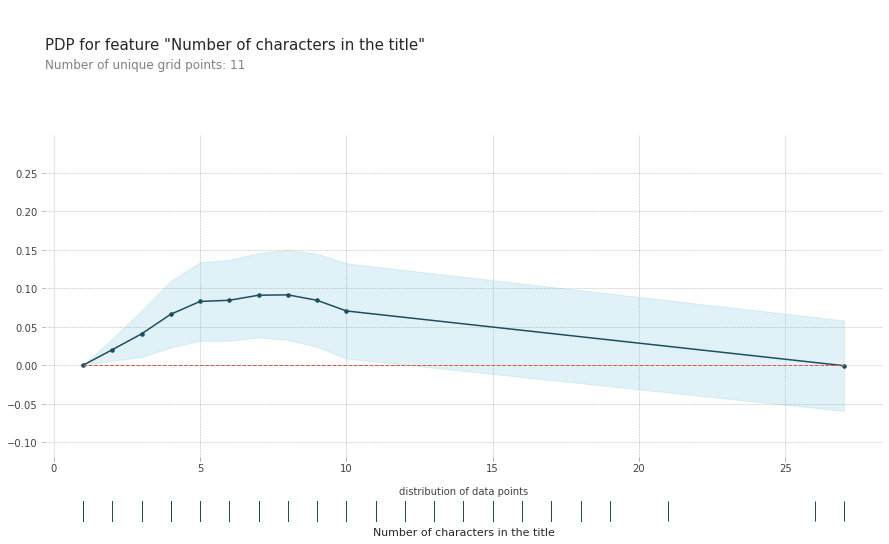

In [106]:
pdp_to_deadline = pdp.pdp_isolate(model=clf, dataset=X_train, model_features=data_features, 
                          feature="name_words", num_grid_points=20)
ax = pdp.pdp_plot(pdp_to_deadline, 'Number of characters in the title', plot_pts_dist=True)
plt.show()

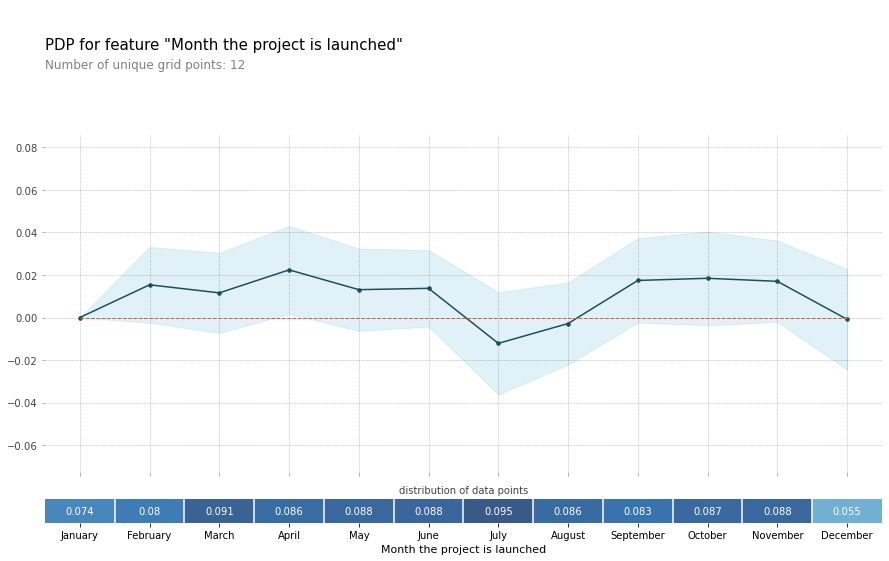

In [60]:
months = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]
launched_month_feature = ["launched_month_" + month for month in months]

pdp_month = pdp.pdp_isolate(model=clf, dataset=X_test, model_features=data_features, 
                            feature=launched_month_feature)
ax = pdp.pdp_plot(pdp_month, 'Month the project is launched', plot_pts_dist=True)
c_ax = ax[1]["pdp_ax"]['_count_ax']
labels = [item for item in c_ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i].set_text(months[i])
c_ax.set_xticklabels(labels)
plt.show()

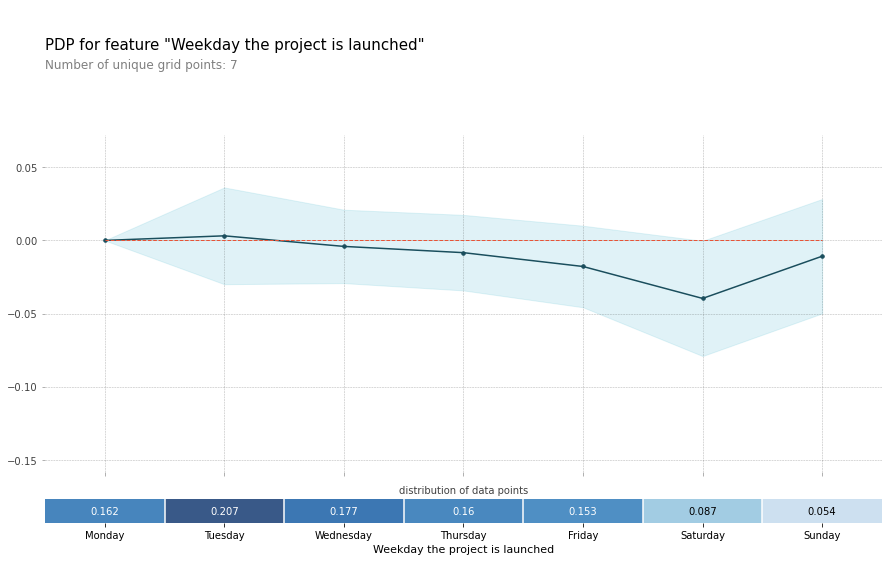

In [62]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
launched_day_feature = ["launched_day_" + day for day in days]

pdp_day = pdp.pdp_isolate(model=clf, dataset=X_test, model_features=data_features, 
                          feature=launched_day_feature)
ax = pdp.pdp_plot(pdp_day, 'Weekday the project is launched', plot_pts_dist=True)
c_ax = ax[1]["pdp_ax"]['_count_ax']
labels = [item for item in c_ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i].set_text(days[i])
c_ax.set_xticklabels(labels)
plt.show()

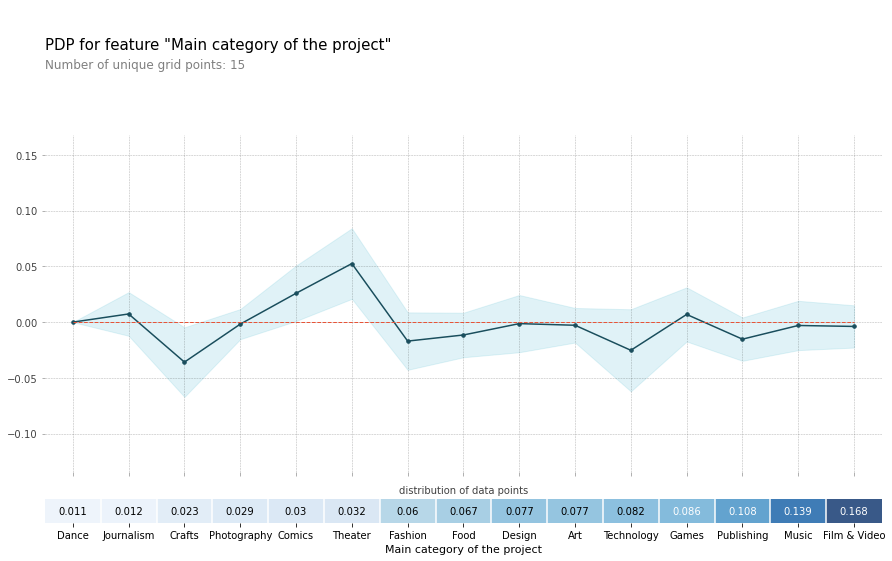

In [88]:
category_labels = [col for col in df["main_category"].value_counts().keys()]
category_labels.reverse()
category_features = ["main_category_" + label for label in category_labels]
pdp_day = pdp.pdp_isolate(model=clf, dataset=X_test, model_features=data_features, 
                          feature=category_features)
ax = pdp.pdp_plot(pdp_day, 'Main category of the project', plot_pts_dist=True)
c_ax = ax[1]["pdp_ax"]['_count_ax']
labels = [item for item in c_ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i].set_text(category_labels[i])
c_ax.set_xticklabels(labels)
plt.show()

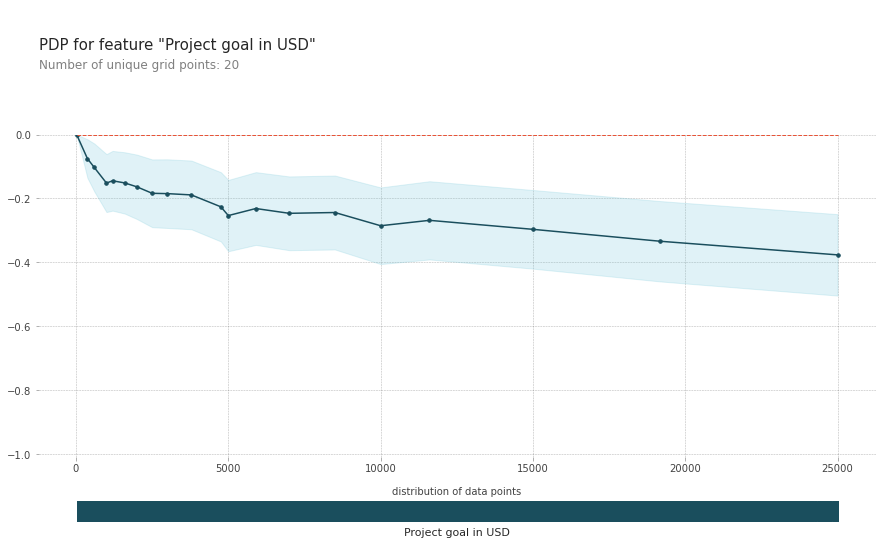

In [102]:
data = X.loc[X["usd_goal_real"] < 25000]
pdp_to_deadline = pdp.pdp_isolate(model=clf, dataset=data, model_features=data_features, 
                          feature="usd_goal_real", num_grid_points=20)
ax = pdp.pdp_plot(pdp_to_deadline, 'Project goal in USD', plot_pts_dist=True)
plt.show()

Text(0.5, 1.0, 'Feature importances')

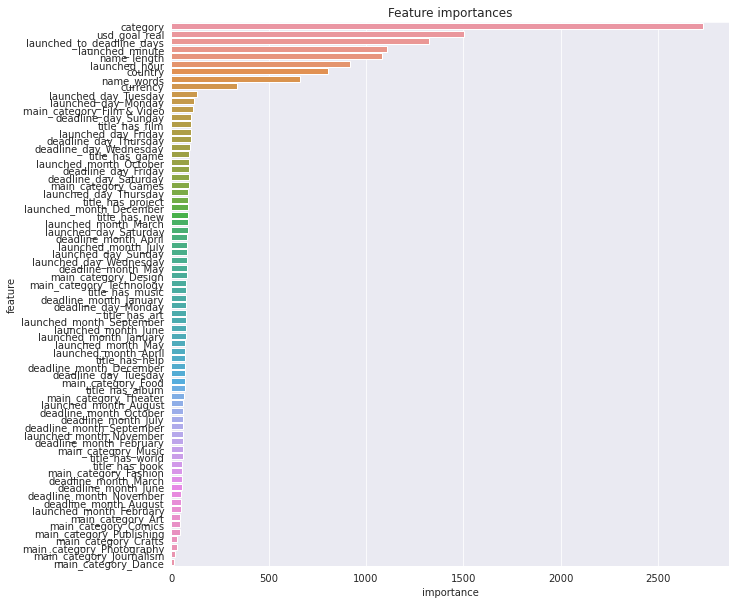

In [99]:
import seaborn as sns
feature_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": clf.feature_importances_
             })

feature_df = feature_df.sort_values(by="importance", ascending=False)

sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize=(10, 10))
sns.barplot(y="feature", x="importance", data=feature_df, orient="h", ax=ax)
ax.set_title("Feature importances")